In [117]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
import numpy as np

In [118]:
# Loading the dataset

df = pd.read_csv('Apache_2k_modified.csv')

In [119]:
df.head()

,LineId,Time,Level,Content,EventId,EventTemplate
0,1,Sun Dec 04 04:47:44 2005,notice,workerEnv.init() ok /etc/httpd/conf/workers2.p...,workerEnv.init\(\) ok <*>,workerEnv.init() ok <*>
1,2,Sun Dec 04 04:47:44 2005,error,mod_jk child workerEnv in error state 6,mod_jk child workerEnv in error state <*>,mod_jk child workerEnv in error state <*>
2,3,Sun Dec 04 04:51:08 2005,notice,jk2_init() Found child 6725 in scoreboard slot 10,jk2_init\(\) Found child <*> in scoreboard slo...,jk2_init() Found child <*> in scoreboard slot <*>
3,4,Sun Dec 04 04:51:09 2005,notice,jk2_init() Found child 6726 in scoreboard slot 8,jk2_init\(\) Found child <*> in scoreboard slo...,jk2_init() Found child <*> in scoreboard slot <*>
4,5,Sun Dec 04 04:51:09 2005,notice,jk2_init() Found child 6728 in scoreboard slot 6,jk2_init\(\) Found child <*> in scoreboard slo...,jk2_init() Found child <*> in scoreboard slot <*>


In [120]:
df.isnull().sum()

LineId           0
Time             0
Level            0
Content          0
EventId          0
EventTemplate    0
dtype: int64

In [121]:
len(df)

2000

In [122]:
df = df.drop_duplicates()

In [123]:
len(df)

2000

In [124]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score, roc_curve, auc
import matplotlib.pyplot as plt

In [125]:
label_encoder = LabelEncoder()
df['Level_encoded'] = label_encoder.fit_transform(df['Level'])

In [126]:
tfidf = TfidfVectorizer(max_features=100)
content_tfidf = tfidf.fit_transform(df['Content']).toarray()
X = np.hstack((df[['Level_encoded']].values, content_tfidf))

In [127]:
# Step 1: Isolation Forest

X_train = X
iso_forest = IsolationForest(contamination=0.05, random_state=42).fit(X_train)
pred_iso = iso_forest.predict(X_train)
scores_iso = -iso_forest.decision_function(X_train)

In [128]:
# Retain only normal instances for the next model
X_refined_1 = X_train[pred_iso == 1]

In [129]:
# Step 2: Local Outlier Factor(LOF)

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
pred_lof = lof.fit_predict(X_refined_1)
scores_lof = -lof.negative_outlier_factor_

/home/kairaj5456/.local/bin/new/lib/python3.12/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


In [130]:
#Retain only normal instances for the next model

X_refined_2 = X_refined_1[pred_lof == 1]

In [131]:
# Step 3: One-Class SVM

oc_svm = OneClassSVM(nu=0.03,kernel="rbf",gamma="auto")
oc_svm.fit(X_refined_2)
pred_svm = oc_svm.predict(X_train)
scores_svm = -oc_svm.decision_function(X_train)

In [132]:
labels_combined = [1 if p==1 else 0 for p in pred_svm]

In [133]:
if len(set(labels_combined)) > 1:
    silhouette_final = silhouette_score(X_train, labels_combined)
    print("Silhouette Score for Sequential Ensemble Model :", silhouette_final)

Silhouette Score for Sequential Ensemble Model : 0.6169500164993431


In [144]:
print(f"Isolation Forest Detected {np.sum(pred_iso == 1)} Anomalies")
print(f"LOF Detected {np.sum(pred_lof == -1)} Anomalies")
print(f"SVM Detected {np.sum(pred_svm == -1)} Anomalies")

Isolation Forest Detected 1900 Anomalies
LOF Detected 26 Anomalies
SVM Detected 1340 Anomalies


In [135]:
# Generate ROC Curve and AUC using One-Class SVM scores as an example

fpr, tpr, thresholds = roc_curve(labels_combined, scores_svm)
roc_auc = auc(fpr,tpr)

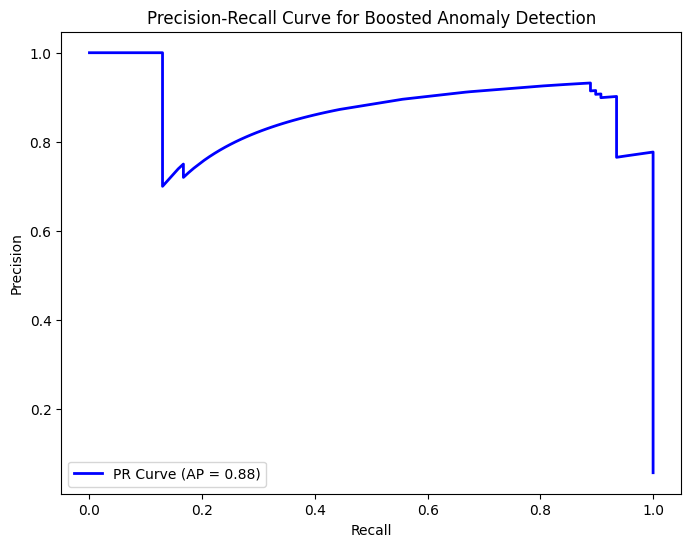

Average Precision (AP): 0.883


In [136]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Ensure all models have the same length for labels and scores
min_length = min(len(pred_iso), len(pred_lof), len(pred_svm))
pred_iso = pred_iso[:min_length]
pred_lof = pred_lof[:min_length]
pred_svm = pred_svm[:min_length]

scores_iso = scores_iso[:min_length]
scores_lof = scores_lof[:min_length]
scores_svm = scores_svm[:min_length]

# Convert predictions to binary labels (1 = anomaly, 0 = normal)
labels_iso = [1 if p == -1 else 0 for p in pred_iso]
labels_lof = [1 if p == -1 else 0 for p in pred_lof]
labels_svm = [1 if p == -1 else 0 for p in pred_svm]

# Combine labels using majority vote
combined_labels = np.array([1 if (l_iso + l_lof + l_svm) >= 2 else 0 
                            for l_iso, l_lof, l_svm in zip(labels_iso, labels_lof, labels_svm)])

# Combine scores using the average of all three
combined_scores = (scores_iso + scores_lof + scores_svm) / 3

# ✅ Calculate Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(combined_labels, combined_scores)
average_precision = average_precision_score(combined_labels, combined_scores)

# 📊 Plot PR Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR Curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Boosted Anomaly Detection')
plt.legend(loc="lower left")
plt.show()

# 📌 Print Average Precision
print(f"Average Precision (AP): {average_precision:.3f}")


In [137]:
min_length = min(len(pred_iso), len(pred_lof), len(pred_svm))
pred_iso = pred_iso[:min_length]
pred_lof = pred_lof[:min_length]
pred_svm = pred_svm[:min_length]

scores_iso = scores_iso[:min_length]
scores_lof = scores_lof[:min_length]
scores_svm = scores_svm[:min_length]


Isolation Forest Detected 100 Anomalies
Isolation Forest Detected 1900 Normal points


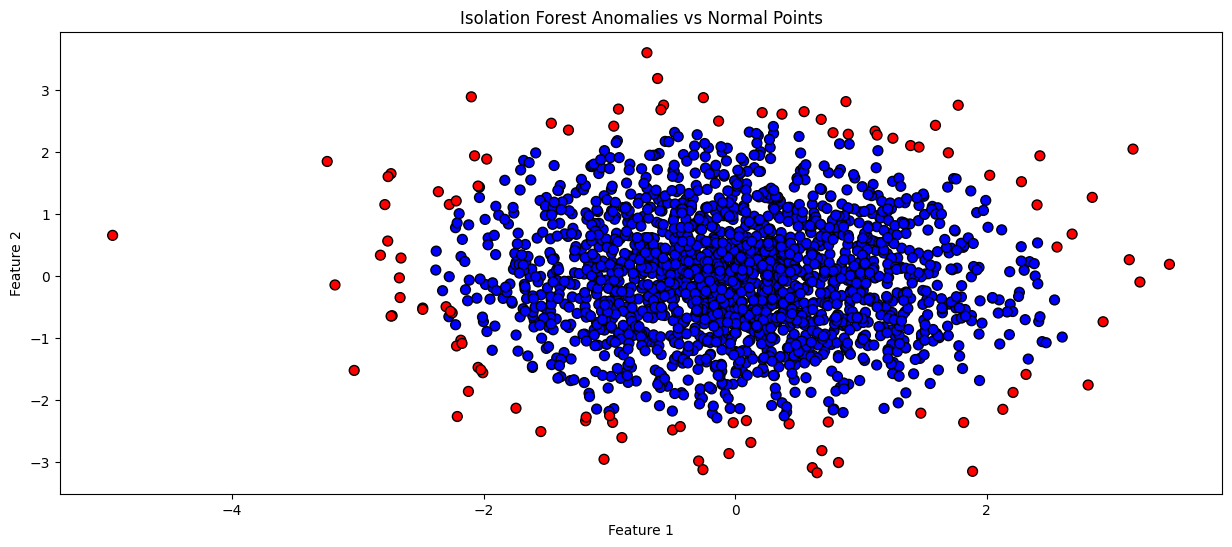

Silhouette Score for Isolation Forest Model: 0.4167438133616468


In [150]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score

# Example of your dataset (2D for visualization purposes)
# Replace this with your actual dataset

# Print detected anomalies
print(f"Isolation Forest Detected {np.sum(pred_iso == -1)} Anomalies")
print(f"Isolation Forest Detected {np.sum(pred_iso == 1)} Normal points")

# Step 2: Plot all points, coloring based on anomaly detection
plt.figure(figsize=(15, 6))
plt.scatter(X[:, 0], X[:, 1], c=np.where(pred_iso == -1, 'red', 'blue'), edgecolors='k', s=50)

# Set title and labels
plt.title("Isolation Forest Anomalies vs Normal Points")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Display the plot
plt.show()

# Compute the silhouette score (if necessary)
# For silhouette score, we need to label normal and anomaly points
labels_combined = [1 if p == 1 else 0 for p in pred_iso]  # Convert to 0 for anomalies, 1 for normal
if len(set(labels_combined)) > 1:
    silhouette_final = silhouette_score(X, labels_combined)
    print("Silhouette Score for Isolation Forest Model:", silhouette_final)


Length of X_refined_1: 1900, Length of pred_lof: 1900
LOF Detected 26 Anomalies
LOF Detected 1874 Normal points


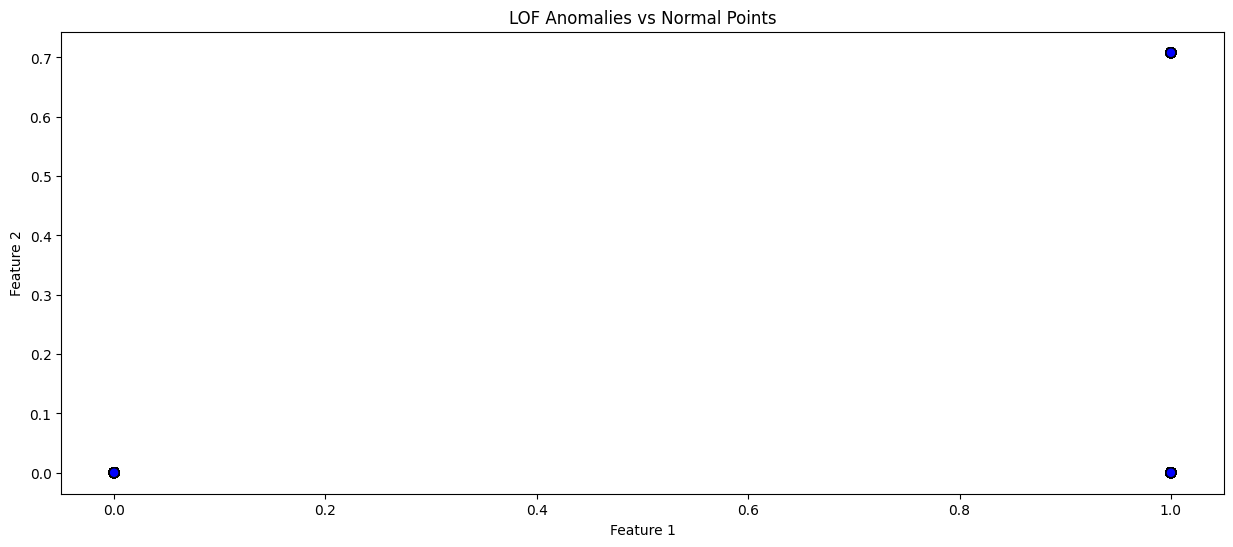

Silhouette Score for LOF Model: 0.19720088842236894


In [36]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import silhouette_score


# Verify lengths of X_refined_1 and pred_lof
print(f"Length of X_refined_1: {len(X_refined_1)}, Length of pred_lof: {len(pred_lof)}")

# Print detected anomalies and normal points
print(f"LOF Detected {np.sum(pred_lof == -1)} Anomalies")
print(f"LOF Detected {np.sum(pred_lof == 1)} Normal points")

# Step 2: Plot all points, coloring based on anomaly detection
plt.figure(figsize=(15, 6))
plt.scatter(X_refined_1[:, 0], X_refined_1[:, 1], c=np.where(pred_lof == -1, 'red', 'blue'), edgecolors='k', s=50)

# Set title and labels
plt.title("LOF Anomalies vs Normal Points")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Display the plot
plt.show()

# Compute the silhouette score (if applicable)
labels_combined = [1 if p == 1 else 0 for p in pred_lof]  
if len(set(labels_combined)) > 1:
    silhouette_final = silhouette_score(X_refined_1, labels_combined)
    print("Silhouette Score for LOF Model:", silhouette_final)
else:
    print("Silhouette score not computed as only one class is present.")


In [33]:
print(f"Length of X: {len(X)}, Length of pred_svm: {len(pred_svm)}")

Length of X: 2000, Length of pred_svm: 2000


SVM Detected 200 Anomalies
SVM Detected 1800 Normal points


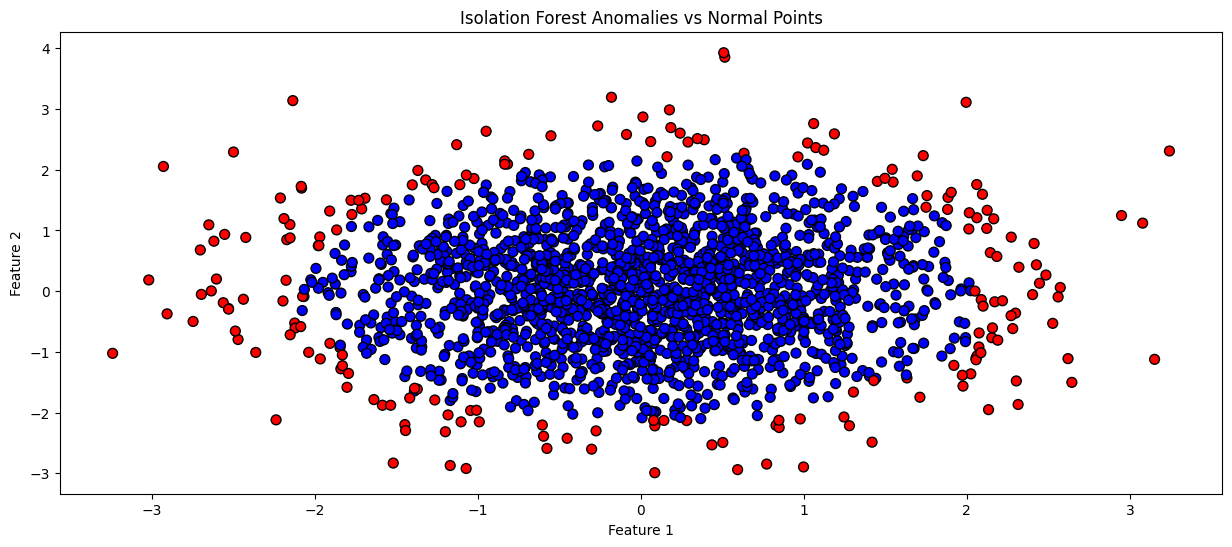

Silhouette Score for Isolation Forest Model: 0.3639217811979819


In [35]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score


# Print detected anomalies
print(f"SVM Detected {np.sum(pred_svm == -1)} Anomalies")
print(f"SVM Detected {np.sum(pred_svm == 1)} Normal points")

# Step 2: Plot all points, coloring based on anomaly detection
plt.figure(figsize=(15, 6))
plt.scatter(X[:, 0], X[:, 1], c=np.where(pred_svm == -1, 'red', 'blue'), edgecolors='k', s=50)

# Set title and labels
plt.title("Isolation Forest Anomalies vs Normal Points")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Display the plot
plt.show()

# Compute the silhouette score if applicable
labels_combined = [1 if p == 1 else 0 for p in pred_svm]  
if len(set(labels_combined)) > 1:
    silhouette_final = silhouette_score(X, labels_combined)
    print("Silhouette Score for Isolation Forest Model:", silhouette_final)


In [37]:
import joblib
# Saving models and preprocessing steps using joblib

# Save the Isolation Forest model
joblib.dump(iso_forest, 'iso_forest_model.pkl')

# Save the LOF model
joblib.dump(lof, 'lof_model.pkl')

# Save the One-Class SVM model
joblib.dump(oc_svm, 'oc_svm_model.pkl')

# Save the TfidfVectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

# Save the LabelEncoder (for the 'Level' column encoding)
joblib.dump(label_encoder, 'label_encoder.pkl')

print("Models and preprocessing steps saved successfully!")

Models and preprocessing steps saved successfully!
